In [88]:
# Imports
import evaluate
import torch
import wandb
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

from transformers import AutoModelForImageClassification, AutoImageProcessor, TrainingArguments, Trainer, DefaultDataCollator, pipeline
from datasets import load_dataset
from pathlib import Path

from hf_models.models.spice_cnn.image_processing_spice_cnn import SpiceCNNImageProcessor

HOME_DIRECTORY = Path.home()
MODEL_DIRECTORY = "spice-cnn-base"
MODEL_CACHE_DIRECTORY = Path(HOME_DIRECTORY / ".cache" / "hf-models" / MODEL_DIRECTORY)
MODEL_CACHE_DIRECTORY.mkdir(parents=True, exist_ok=True)

Found cached dataset mnist (/Users/ankush/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


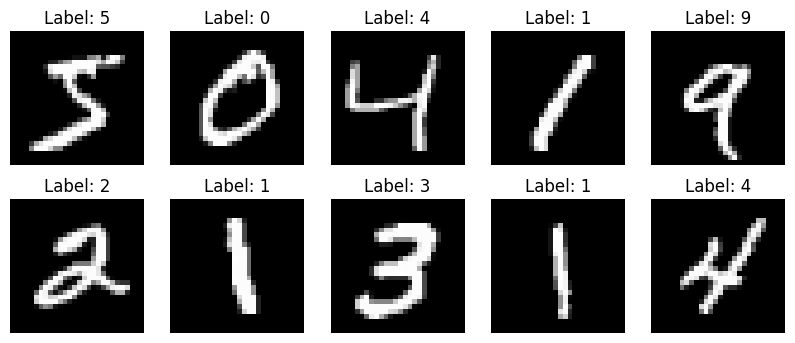

In [89]:
# Visualize the images
mnist_train = load_dataset("mnist", split="train")

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))

for i, ax in enumerate(axes.flatten()):
    image = mnist_train[i]["image"]
    label = mnist_train[i]["label"]
    image_array = np.array(image, dtype=np.float32)
    ax.imshow(image_array.squeeze(), cmap="gray")  # Squeeze the array if necessary
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.show()

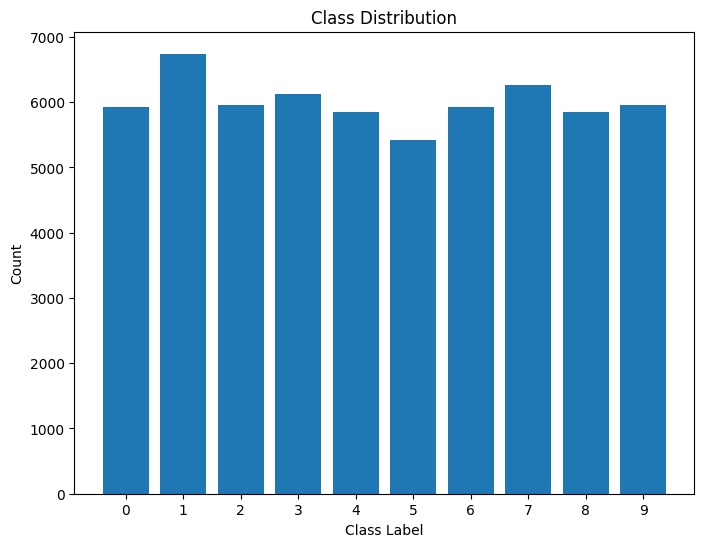

In [90]:
# Analyze the dataset
labels = mnist_train["label"]

# Calculate the class distribution
class_counts = np.bincount(labels)
class_labels = np.arange(10)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts)
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(class_labels)
plt.show()

In [91]:
# Load mnist dataset
mnist = load_dataset("mnist", split="train")
mnist = mnist.train_test_split(test_size=0.2)

labels = mnist["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

Found cached dataset mnist (/Users/ankush/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


In [92]:
# Preprocess mnist dataset
image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="spicecloud/spice-cnn-base",
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
    trust_remote_code=True,
    size={"height": 28, "width": 28},
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(examples):
    examples["tensor"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

mnist = mnist.with_transform(transforms)
data_collator = DefaultDataCollator()

A new version of the following files was downloaded from https://huggingface.co/spicecloud/spice-cnn-base:
- image_processing_spice_cnn.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [93]:
from torchsummary import summary
model = AutoModelForImageClassification.from_pretrained(
    pretrained_model_name_or_path="spicecloud/spice-cnn-base",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    trust_remote_code=True,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.model = model.model.to(device)

summary(model.model, input_size=(3,28,28))

A new version of the following files was downloaded from https://huggingface.co/spicecloud/spice-cnn-base:
- configuration_spice_cnn.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/spicecloud/spice-cnn-base:
- modeling_spice_cnn.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             448
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
           Flatten-7                 [-1, 1568]               0
            Linear-8                  [-1, 128]         200,832
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 207,210
Trainable params: 207,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.34
Params size (MB): 0.79
Estimated T

In [94]:
# Evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [95]:
# Train
model = AutoModelForImageClassification.from_pretrained(
    pretrained_model_name_or_path="spicecloud/spice-cnn-base",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    trust_remote_code=True,
)

training_args = TrainingArguments(
    output_dir=MODEL_CACHE_DIRECTORY,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4, # number of update steps to accumulate the gradient for before a backward pass
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    warmup_ratio=0.1, # ratio of total training steps used for a linear warmup from 0 to 'learning_rate'
    logging_steps=10, # number of update steps between two logs
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=mnist["train"],
    eval_dataset=mnist["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb.finish()

/Users/ankush/Library/Caches/pypoetry/virtualenvs/hf-models-JChwTGhx-py3.11/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/7500 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 2.3019, 'learning_rate': 1.3333333333333335e-05, 'epoch': 0.03}
{'loss': 2.3054, 'learning_rate': 2.666666666666667e-05, 'epoch': 0.05}
{'loss': 2.299, 'learning_rate': 4e-05, 'epoch': 0.08}
{'loss': 2.2969, 'learning_rate': 5.333333333333334e-05, 'epoch': 0.11}
{'loss': 2.294, 'learning_rate': 6.666666666666667e-05, 'epoch': 0.13}
{'loss': 2.2872, 'learning_rate': 8e-05, 'epoch': 0.16}
{'loss': 2.2745, 'learning_rate': 9.333333333333334e-05, 'epoch': 0.19}
{'loss': 2.2682, 'learning_rate': 0.00010666666666666668, 'epoch': 0.21}
{'loss': 2.2507, 'learning_rate': 0.00012, 'epoch': 0.24}
{'loss': 2.2225, 'learning_rate': 0.00013333333333333334, 'epoch': 0.27}
{'loss': 2.1825, 'learning_rate': 0.00014666666666666666, 'epoch': 0.29}
{'loss': 2.1148, 'learning_rate': 0.00016, 'epoch': 0.32}
{'loss': 2.0474, 'learning_rate': 0.00017333333333333334, 'epoch': 0.35}
{'loss': 2.009, 'learning_rate': 0.0001866666666666667, 'epoch': 0.37}
{'loss': 1.9267, 'learning_rate': 0.0002, 'epoch':

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 1.2377411127090454, 'eval_accuracy': 0.6011666666666666, 'eval_runtime': 2.7541, 'eval_samples_per_second': 4357.188, 'eval_steps_per_second': 136.162, 'epoch': 1.0}
{'loss': 1.2449, 'learning_rate': 0.0005066666666666668, 'epoch': 1.01}
{'loss': 1.1899, 'learning_rate': 0.0005200000000000001, 'epoch': 1.04}
{'loss': 1.1961, 'learning_rate': 0.0005333333333333334, 'epoch': 1.07}
{'loss': 1.1524, 'learning_rate': 0.0005466666666666667, 'epoch': 1.09}
{'loss': 1.1098, 'learning_rate': 0.0005600000000000001, 'epoch': 1.12}
{'loss': 1.094, 'learning_rate': 0.0005733333333333334, 'epoch': 1.15}
{'loss': 1.1264, 'learning_rate': 0.0005866666666666667, 'epoch': 1.17}
{'loss': 1.0618, 'learning_rate': 0.0006, 'epoch': 1.2}
{'loss': 1.1309, 'learning_rate': 0.0006133333333333334, 'epoch': 1.23}
{'loss': 1.0829, 'learning_rate': 0.0006266666666666668, 'epoch': 1.25}
{'loss': 1.1036, 'learning_rate': 0.00064, 'epoch': 1.28}
{'loss': 1.0667, 'learning_rate': 0.0006533333333333333, 'e

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.8329897522926331, 'eval_accuracy': 0.7295, 'eval_runtime': 2.7099, 'eval_samples_per_second': 4428.147, 'eval_steps_per_second': 138.38, 'epoch': 2.0}
{'loss': 0.781, 'learning_rate': 0.0009985185185185186, 'epoch': 2.03}
{'loss': 0.7914, 'learning_rate': 0.0009970370370370372, 'epoch': 2.05}
{'loss': 0.7613, 'learning_rate': 0.0009955555555555555, 'epoch': 2.08}
{'loss': 0.7969, 'learning_rate': 0.000994074074074074, 'epoch': 2.11}
{'loss': 0.7598, 'learning_rate': 0.0009925925925925927, 'epoch': 2.13}
{'loss': 0.8211, 'learning_rate': 0.0009911111111111112, 'epoch': 2.16}
{'loss': 0.7552, 'learning_rate': 0.0009896296296296296, 'epoch': 2.19}
{'loss': 0.7564, 'learning_rate': 0.0009881481481481482, 'epoch': 2.21}
{'loss': 0.781, 'learning_rate': 0.0009866666666666667, 'epoch': 2.24}
{'loss': 0.7487, 'learning_rate': 0.000985185185185185, 'epoch': 2.27}
{'loss': 0.761, 'learning_rate': 0.0009837037037037039, 'epoch': 2.29}
{'loss': 0.823, 'learning_rate': 0.00098222222

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.6825161576271057, 'eval_accuracy': 0.7714166666666666, 'eval_runtime': 2.737, 'eval_samples_per_second': 4384.292, 'eval_steps_per_second': 137.009, 'epoch': 3.0}
{'loss': 0.7066, 'learning_rate': 0.0009437037037037038, 'epoch': 3.01}
{'loss': 0.656, 'learning_rate': 0.0009422222222222222, 'epoch': 3.04}
{'loss': 0.6683, 'learning_rate': 0.0009407407407407408, 'epoch': 3.07}
{'loss': 0.6969, 'learning_rate': 0.0009392592592592593, 'epoch': 3.09}
{'loss': 0.6693, 'learning_rate': 0.0009377777777777778, 'epoch': 3.12}
{'loss': 0.6798, 'learning_rate': 0.0009362962962962963, 'epoch': 3.15}
{'loss': 0.6447, 'learning_rate': 0.0009348148148148148, 'epoch': 3.17}
{'loss': 0.674, 'learning_rate': 0.0009333333333333333, 'epoch': 3.2}
{'loss': 0.6911, 'learning_rate': 0.0009318518518518518, 'epoch': 3.23}
{'loss': 0.6843, 'learning_rate': 0.0009303703703703705, 'epoch': 3.25}
{'loss': 0.6518, 'learning_rate': 0.0009288888888888889, 'epoch': 3.28}
{'loss': 0.6876, 'learning_rate'

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.6202163696289062, 'eval_accuracy': 0.7919166666666667, 'eval_runtime': 2.7108, 'eval_samples_per_second': 4426.734, 'eval_steps_per_second': 138.335, 'epoch': 4.0}
{'loss': 0.6358, 'learning_rate': 0.0008874074074074074, 'epoch': 4.03}
{'loss': 0.5784, 'learning_rate': 0.000885925925925926, 'epoch': 4.05}
{'loss': 0.6147, 'learning_rate': 0.0008844444444444445, 'epoch': 4.08}
{'loss': 0.549, 'learning_rate': 0.000882962962962963, 'epoch': 4.11}
{'loss': 0.5865, 'learning_rate': 0.0008814814814814816, 'epoch': 4.13}
{'loss': 0.5765, 'learning_rate': 0.00088, 'epoch': 4.16}
{'loss': 0.5994, 'learning_rate': 0.0008785185185185185, 'epoch': 4.19}
{'loss': 0.6177, 'learning_rate': 0.0008770370370370371, 'epoch': 4.21}
{'loss': 0.6256, 'learning_rate': 0.0008755555555555555, 'epoch': 4.24}
{'loss': 0.5705, 'learning_rate': 0.0008740740740740741, 'epoch': 4.27}
{'loss': 0.555, 'learning_rate': 0.0008725925925925926, 'epoch': 4.29}
{'loss': 0.5909, 'learning_rate': 0.0008711111

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.5602456331253052, 'eval_accuracy': 0.8131666666666667, 'eval_runtime': 2.7346, 'eval_samples_per_second': 4388.268, 'eval_steps_per_second': 137.133, 'epoch': 5.0}
{'loss': 0.5613, 'learning_rate': 0.0008325925925925926, 'epoch': 5.01}
{'loss': 0.5849, 'learning_rate': 0.0008311111111111111, 'epoch': 5.04}
{'loss': 0.5592, 'learning_rate': 0.0008296296296296296, 'epoch': 5.07}
{'loss': 0.5236, 'learning_rate': 0.0008281481481481482, 'epoch': 5.09}
{'loss': 0.5809, 'learning_rate': 0.0008266666666666666, 'epoch': 5.12}
{'loss': 0.611, 'learning_rate': 0.0008251851851851852, 'epoch': 5.15}
{'loss': 0.5446, 'learning_rate': 0.0008237037037037038, 'epoch': 5.17}
{'loss': 0.5169, 'learning_rate': 0.0008222222222222222, 'epoch': 5.2}
{'loss': 0.5616, 'learning_rate': 0.0008207407407407408, 'epoch': 5.23}
{'loss': 0.58, 'learning_rate': 0.0008192592592592593, 'epoch': 5.25}
{'loss': 0.5359, 'learning_rate': 0.0008177777777777778, 'epoch': 5.28}
{'loss': 0.5479, 'learning_rate'

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.5351625084877014, 'eval_accuracy': 0.8195833333333333, 'eval_runtime': 2.7479, 'eval_samples_per_second': 4367.0, 'eval_steps_per_second': 136.469, 'epoch': 6.0}
{'loss': 0.5354, 'learning_rate': 0.0007762962962962963, 'epoch': 6.03}
{'loss': 0.5296, 'learning_rate': 0.0007748148148148149, 'epoch': 6.05}
{'loss': 0.5075, 'learning_rate': 0.0007733333333333333, 'epoch': 6.08}
{'loss': 0.4824, 'learning_rate': 0.0007718518518518519, 'epoch': 6.11}
{'loss': 0.5469, 'learning_rate': 0.0007703703703703704, 'epoch': 6.13}
{'loss': 0.5172, 'learning_rate': 0.0007688888888888888, 'epoch': 6.16}
{'loss': 0.5563, 'learning_rate': 0.0007674074074074074, 'epoch': 6.19}
{'loss': 0.4675, 'learning_rate': 0.0007659259259259259, 'epoch': 6.21}
{'loss': 0.5047, 'learning_rate': 0.0007644444444444445, 'epoch': 6.24}
{'loss': 0.5187, 'learning_rate': 0.000762962962962963, 'epoch': 6.27}
{'loss': 0.5239, 'learning_rate': 0.0007614814814814816, 'epoch': 6.29}
{'loss': 0.5307, 'learning_rate

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.5051928758621216, 'eval_accuracy': 0.82925, 'eval_runtime': 2.7488, 'eval_samples_per_second': 4365.545, 'eval_steps_per_second': 136.423, 'epoch': 7.0}
{'loss': 0.5324, 'learning_rate': 0.0007214814814814815, 'epoch': 7.01}
{'loss': 0.5273, 'learning_rate': 0.0007199999999999999, 'epoch': 7.04}
{'loss': 0.5105, 'learning_rate': 0.0007185185185185186, 'epoch': 7.07}
{'loss': 0.5112, 'learning_rate': 0.0007170370370370371, 'epoch': 7.09}
{'loss': 0.4726, 'learning_rate': 0.0007155555555555555, 'epoch': 7.12}
{'loss': 0.5199, 'learning_rate': 0.0007140740740740741, 'epoch': 7.15}
{'loss': 0.4681, 'learning_rate': 0.0007125925925925926, 'epoch': 7.17}
{'loss': 0.5364, 'learning_rate': 0.0007111111111111111, 'epoch': 7.2}
{'loss': 0.533, 'learning_rate': 0.0007096296296296296, 'epoch': 7.23}
{'loss': 0.5242, 'learning_rate': 0.0007081481481481482, 'epoch': 7.25}
{'loss': 0.4552, 'learning_rate': 0.0007066666666666666, 'epoch': 7.28}
{'loss': 0.5108, 'learning_rate': 0.00070

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.4880428910255432, 'eval_accuracy': 0.8351666666666666, 'eval_runtime': 2.7047, 'eval_samples_per_second': 4436.711, 'eval_steps_per_second': 138.647, 'epoch': 8.0}
{'loss': 0.4854, 'learning_rate': 0.0006651851851851852, 'epoch': 8.03}
{'loss': 0.4678, 'learning_rate': 0.0006637037037037037, 'epoch': 8.05}
{'loss': 0.4867, 'learning_rate': 0.0006622222222222222, 'epoch': 8.08}
{'loss': 0.4966, 'learning_rate': 0.0006607407407407407, 'epoch': 8.11}
{'loss': 0.479, 'learning_rate': 0.0006592592592592592, 'epoch': 8.13}
{'loss': 0.4618, 'learning_rate': 0.0006577777777777779, 'epoch': 8.16}
{'loss': 0.5179, 'learning_rate': 0.0006562962962962963, 'epoch': 8.19}
{'loss': 0.4649, 'learning_rate': 0.0006548148148148149, 'epoch': 8.21}
{'loss': 0.4707, 'learning_rate': 0.0006533333333333333, 'epoch': 8.24}
{'loss': 0.4621, 'learning_rate': 0.0006518518518518519, 'epoch': 8.27}
{'loss': 0.5279, 'learning_rate': 0.0006503703703703704, 'epoch': 8.29}
{'loss': 0.5183, 'learning_ra

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.46504151821136475, 'eval_accuracy': 0.844, 'eval_runtime': 2.7273, 'eval_samples_per_second': 4399.921, 'eval_steps_per_second': 137.498, 'epoch': 9.0}
{'loss': 0.5136, 'learning_rate': 0.0006103703703703704, 'epoch': 9.01}
{'loss': 0.4794, 'learning_rate': 0.000608888888888889, 'epoch': 9.04}
{'loss': 0.4167, 'learning_rate': 0.0006074074074074074, 'epoch': 9.07}
{'loss': 0.4628, 'learning_rate': 0.000605925925925926, 'epoch': 9.09}
{'loss': 0.4681, 'learning_rate': 0.0006044444444444445, 'epoch': 9.12}
{'loss': 0.4948, 'learning_rate': 0.0006029629629629629, 'epoch': 9.15}
{'loss': 0.4205, 'learning_rate': 0.0006014814814814815, 'epoch': 9.17}
{'loss': 0.4307, 'learning_rate': 0.0006, 'epoch': 9.2}
{'loss': 0.493, 'learning_rate': 0.0005985185185185186, 'epoch': 9.23}
{'loss': 0.4774, 'learning_rate': 0.0005970370370370371, 'epoch': 9.25}
{'loss': 0.4796, 'learning_rate': 0.0005955555555555556, 'epoch': 9.28}
{'loss': 0.48, 'learning_rate': 0.0005940740740740741, 'epo

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.4670523703098297, 'eval_accuracy': 0.84375, 'eval_runtime': 2.7379, 'eval_samples_per_second': 4382.886, 'eval_steps_per_second': 136.965, 'epoch': 10.0}
{'loss': 0.4809, 'learning_rate': 0.000554074074074074, 'epoch': 10.03}
{'loss': 0.4219, 'learning_rate': 0.0005525925925925927, 'epoch': 10.05}
{'loss': 0.4413, 'learning_rate': 0.0005511111111111112, 'epoch': 10.08}
{'loss': 0.4771, 'learning_rate': 0.0005496296296296296, 'epoch': 10.11}
{'loss': 0.4854, 'learning_rate': 0.0005481481481481482, 'epoch': 10.13}
{'loss': 0.4751, 'learning_rate': 0.0005466666666666667, 'epoch': 10.16}
{'loss': 0.4994, 'learning_rate': 0.0005451851851851852, 'epoch': 10.19}
{'loss': 0.4471, 'learning_rate': 0.0005437037037037037, 'epoch': 10.21}
{'loss': 0.4547, 'learning_rate': 0.0005422222222222223, 'epoch': 10.24}
{'loss': 0.4561, 'learning_rate': 0.0005407407407407407, 'epoch': 10.27}
{'loss': 0.4646, 'learning_rate': 0.0005392592592592592, 'epoch': 10.29}
{'loss': 0.5115, 'learning_r

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.4557141959667206, 'eval_accuracy': 0.8461666666666666, 'eval_runtime': 2.7258, 'eval_samples_per_second': 4402.343, 'eval_steps_per_second': 137.573, 'epoch': 11.0}
{'loss': 0.431, 'learning_rate': 0.0004992592592592593, 'epoch': 11.01}
{'loss': 0.4592, 'learning_rate': 0.0004977777777777778, 'epoch': 11.04}
{'loss': 0.4181, 'learning_rate': 0.0004962962962962963, 'epoch': 11.07}
{'loss': 0.4355, 'learning_rate': 0.0004948148148148148, 'epoch': 11.09}
{'loss': 0.4767, 'learning_rate': 0.0004933333333333334, 'epoch': 11.12}
{'loss': 0.4211, 'learning_rate': 0.0004918518518518519, 'epoch': 11.15}
{'loss': 0.4923, 'learning_rate': 0.0004903703703703704, 'epoch': 11.17}
{'loss': 0.4562, 'learning_rate': 0.0004888888888888889, 'epoch': 11.2}
{'loss': 0.4752, 'learning_rate': 0.00048740740740740743, 'epoch': 11.23}
{'loss': 0.4715, 'learning_rate': 0.00048592592592592595, 'epoch': 11.25}
{'loss': 0.4859, 'learning_rate': 0.00048444444444444446, 'epoch': 11.28}
{'loss': 0.4478

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.4544088840484619, 'eval_accuracy': 0.8455833333333334, 'eval_runtime': 2.75, 'eval_samples_per_second': 4363.568, 'eval_steps_per_second': 136.362, 'epoch': 12.0}
{'loss': 0.4436, 'learning_rate': 0.000442962962962963, 'epoch': 12.03}
{'loss': 0.4727, 'learning_rate': 0.0004414814814814815, 'epoch': 12.05}
{'loss': 0.405, 'learning_rate': 0.00044, 'epoch': 12.08}
{'loss': 0.3949, 'learning_rate': 0.00043851851851851853, 'epoch': 12.11}
{'loss': 0.472, 'learning_rate': 0.00043703703703703705, 'epoch': 12.13}
{'loss': 0.4125, 'learning_rate': 0.0004355555555555555, 'epoch': 12.16}
{'loss': 0.4275, 'learning_rate': 0.0004340740740740741, 'epoch': 12.19}
{'loss': 0.4238, 'learning_rate': 0.0004325925925925926, 'epoch': 12.21}
{'loss': 0.4259, 'learning_rate': 0.0004311111111111111, 'epoch': 12.24}
{'loss': 0.4214, 'learning_rate': 0.00042962962962962963, 'epoch': 12.27}
{'loss': 0.4569, 'learning_rate': 0.00042814814814814815, 'epoch': 12.29}
{'loss': 0.4272, 'learning_rate

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.4574103057384491, 'eval_accuracy': 0.8433333333333334, 'eval_runtime': 2.7308, 'eval_samples_per_second': 4394.275, 'eval_steps_per_second': 137.321, 'epoch': 13.0}
{'loss': 0.4526, 'learning_rate': 0.00038814814814814815, 'epoch': 13.01}
{'loss': 0.388, 'learning_rate': 0.00038666666666666667, 'epoch': 13.04}
{'loss': 0.4199, 'learning_rate': 0.0003851851851851852, 'epoch': 13.07}
{'loss': 0.4206, 'learning_rate': 0.0003837037037037037, 'epoch': 13.09}
{'loss': 0.4394, 'learning_rate': 0.0003822222222222223, 'epoch': 13.12}
{'loss': 0.4034, 'learning_rate': 0.0003807407407407408, 'epoch': 13.15}
{'loss': 0.4379, 'learning_rate': 0.00037925925925925925, 'epoch': 13.17}
{'loss': 0.4285, 'learning_rate': 0.00037777777777777777, 'epoch': 13.2}
{'loss': 0.4361, 'learning_rate': 0.0003762962962962963, 'epoch': 13.23}
{'loss': 0.4521, 'learning_rate': 0.00037481481481481486, 'epoch': 13.25}
{'loss': 0.43, 'learning_rate': 0.0003733333333333334, 'epoch': 13.28}
{'loss': 0.3706

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.4275267720222473, 'eval_accuracy': 0.8551666666666666, 'eval_runtime': 2.7223, 'eval_samples_per_second': 4408.057, 'eval_steps_per_second': 137.752, 'epoch': 14.0}
{'loss': 0.4542, 'learning_rate': 0.00033185185185185184, 'epoch': 14.03}
{'loss': 0.4248, 'learning_rate': 0.00033037037037037036, 'epoch': 14.05}
{'loss': 0.4266, 'learning_rate': 0.0003288888888888889, 'epoch': 14.08}
{'loss': 0.4133, 'learning_rate': 0.00032740740740740744, 'epoch': 14.11}
{'loss': 0.4095, 'learning_rate': 0.00032592592592592596, 'epoch': 14.13}
{'loss': 0.4173, 'learning_rate': 0.0003244444444444444, 'epoch': 14.16}
{'loss': 0.422, 'learning_rate': 0.00032296296296296294, 'epoch': 14.19}
{'loss': 0.4151, 'learning_rate': 0.0003214814814814815, 'epoch': 14.21}
{'loss': 0.4212, 'learning_rate': 0.00032, 'epoch': 14.24}
{'loss': 0.4275, 'learning_rate': 0.00031851851851851854, 'epoch': 14.27}
{'loss': 0.4374, 'learning_rate': 0.00031703703703703706, 'epoch': 14.29}
{'loss': 0.4308, 'learni

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.4137525260448456, 'eval_accuracy': 0.8585833333333334, 'eval_runtime': 2.7445, 'eval_samples_per_second': 4372.376, 'eval_steps_per_second': 136.637, 'epoch': 15.0}
{'loss': 0.403, 'learning_rate': 0.000277037037037037, 'epoch': 15.01}
{'loss': 0.3877, 'learning_rate': 0.0002755555555555556, 'epoch': 15.04}
{'loss': 0.4487, 'learning_rate': 0.0002740740740740741, 'epoch': 15.07}
{'loss': 0.4358, 'learning_rate': 0.0002725925925925926, 'epoch': 15.09}
{'loss': 0.4159, 'learning_rate': 0.00027111111111111113, 'epoch': 15.12}
{'loss': 0.4376, 'learning_rate': 0.0002696296296296296, 'epoch': 15.15}
{'loss': 0.4264, 'learning_rate': 0.00026814814814814816, 'epoch': 15.17}
{'loss': 0.4031, 'learning_rate': 0.0002666666666666667, 'epoch': 15.2}
{'loss': 0.3983, 'learning_rate': 0.0002651851851851852, 'epoch': 15.23}
{'loss': 0.3958, 'learning_rate': 0.0002637037037037037, 'epoch': 15.25}
{'loss': 0.4262, 'learning_rate': 0.00026222222222222223, 'epoch': 15.28}
{'loss': 0.4395,

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.4131750464439392, 'eval_accuracy': 0.861, 'eval_runtime': 2.7063, 'eval_samples_per_second': 4434.138, 'eval_steps_per_second': 138.567, 'epoch': 16.0}
{'loss': 0.4067, 'learning_rate': 0.00022074074074074075, 'epoch': 16.03}
{'loss': 0.4284, 'learning_rate': 0.00021925925925925927, 'epoch': 16.05}
{'loss': 0.4837, 'learning_rate': 0.00021777777777777776, 'epoch': 16.08}
{'loss': 0.3951, 'learning_rate': 0.0002162962962962963, 'epoch': 16.11}
{'loss': 0.4016, 'learning_rate': 0.00021481481481481482, 'epoch': 16.13}
{'loss': 0.3976, 'learning_rate': 0.00021333333333333336, 'epoch': 16.16}
{'loss': 0.4438, 'learning_rate': 0.00021185185185185185, 'epoch': 16.19}
{'loss': 0.4006, 'learning_rate': 0.00021037037037037037, 'epoch': 16.21}
{'loss': 0.3803, 'learning_rate': 0.0002088888888888889, 'epoch': 16.24}
{'loss': 0.4174, 'learning_rate': 0.0002074074074074074, 'epoch': 16.27}
{'loss': 0.3687, 'learning_rate': 0.00020592592592592594, 'epoch': 16.29}
{'loss': 0.3888, 'lea

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.42264774441719055, 'eval_accuracy': 0.8545833333333334, 'eval_runtime': 2.7524, 'eval_samples_per_second': 4359.903, 'eval_steps_per_second': 136.247, 'epoch': 17.0}
{'loss': 0.4243, 'learning_rate': 0.00016592592592592592, 'epoch': 17.01}
{'loss': 0.437, 'learning_rate': 0.00016444444444444446, 'epoch': 17.04}
{'loss': 0.3776, 'learning_rate': 0.00016296296296296298, 'epoch': 17.07}
{'loss': 0.4118, 'learning_rate': 0.00016148148148148147, 'epoch': 17.09}
{'loss': 0.4104, 'learning_rate': 0.00016, 'epoch': 17.12}
{'loss': 0.4283, 'learning_rate': 0.00015851851851851853, 'epoch': 17.15}
{'loss': 0.3914, 'learning_rate': 0.00015703703703703705, 'epoch': 17.17}
{'loss': 0.3718, 'learning_rate': 0.00015555555555555556, 'epoch': 17.2}
{'loss': 0.3569, 'learning_rate': 0.00015407407407407408, 'epoch': 17.23}
{'loss': 0.389, 'learning_rate': 0.0001525925925925926, 'epoch': 17.25}
{'loss': 0.3592, 'learning_rate': 0.0001511111111111111, 'epoch': 17.28}
{'loss': 0.4333, 'learni

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.4096430242061615, 'eval_accuracy': 0.862, 'eval_runtime': 2.7343, 'eval_samples_per_second': 4388.684, 'eval_steps_per_second': 137.146, 'epoch': 18.0}
{'loss': 0.4219, 'learning_rate': 0.00010962962962962963, 'epoch': 18.03}
{'loss': 0.4089, 'learning_rate': 0.00010814814814814815, 'epoch': 18.05}
{'loss': 0.4398, 'learning_rate': 0.00010666666666666668, 'epoch': 18.08}
{'loss': 0.4545, 'learning_rate': 0.00010518518518518518, 'epoch': 18.11}
{'loss': 0.3821, 'learning_rate': 0.0001037037037037037, 'epoch': 18.13}
{'loss': 0.3874, 'learning_rate': 0.00010222222222222223, 'epoch': 18.16}
{'loss': 0.3949, 'learning_rate': 0.00010074074074074075, 'epoch': 18.19}
{'loss': 0.3891, 'learning_rate': 9.925925925925926e-05, 'epoch': 18.21}
{'loss': 0.4221, 'learning_rate': 9.777777777777778e-05, 'epoch': 18.24}
{'loss': 0.3897, 'learning_rate': 9.62962962962963e-05, 'epoch': 18.27}
{'loss': 0.4301, 'learning_rate': 9.481481481481481e-05, 'epoch': 18.29}
{'loss': 0.399, 'learnin

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.4098575711250305, 'eval_accuracy': 0.8604166666666667, 'eval_runtime': 2.7295, 'eval_samples_per_second': 4396.479, 'eval_steps_per_second': 137.39, 'epoch': 19.0}
{'loss': 0.3573, 'learning_rate': 5.4814814814814817e-05, 'epoch': 19.01}
{'loss': 0.4167, 'learning_rate': 5.333333333333334e-05, 'epoch': 19.04}
{'loss': 0.3741, 'learning_rate': 5.185185185185185e-05, 'epoch': 19.07}
{'loss': 0.3916, 'learning_rate': 5.037037037037037e-05, 'epoch': 19.09}
{'loss': 0.4176, 'learning_rate': 4.888888888888889e-05, 'epoch': 19.12}
{'loss': 0.3938, 'learning_rate': 4.7407407407407407e-05, 'epoch': 19.15}
{'loss': 0.3996, 'learning_rate': 4.592592592592593e-05, 'epoch': 19.17}
{'loss': 0.3815, 'learning_rate': 4.4444444444444447e-05, 'epoch': 19.2}
{'loss': 0.3763, 'learning_rate': 4.296296296296296e-05, 'epoch': 19.23}
{'loss': 0.4436, 'learning_rate': 4.148148148148148e-05, 'epoch': 19.25}
{'loss': 0.3779, 'learning_rate': 4e-05, 'epoch': 19.28}
{'loss': 0.3949, 'learning_rate

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 0.41168704628944397, 'eval_accuracy': 0.8599166666666667, 'eval_runtime': 2.414, 'eval_samples_per_second': 4970.947, 'eval_steps_per_second': 155.342, 'epoch': 20.0}
{'train_runtime': 542.5889, 'train_samples_per_second': 1769.295, 'train_steps_per_second': 13.823, 'train_loss': 0.5711382245063782, 'epoch': 20.0}


eval/accuracy,▁▄▆▆▇▇▇▇████▇███████
eval/loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,█▇█▇███▇▇█▇██▇█▇██▇▁
eval/samples_per_second,▁▂▁▂▁▁▁▂▁▁▂▁▁▂▁▂▁▁▁█
eval/steps_per_second,▁▂▁▂▁▁▁▂▁▁▂▁▁▂▁▂▁▁▁█
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▃▅▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
